##### Copyright 2020 The TensorFlow Authors.

In [97]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

Designed to run on local system with training on CPUs.



This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/). 
This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [98]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [99]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import time

print('TensorFlow version: {}'.format(tf.__version__))


TensorFlow version: 2.5.2


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [100]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# splitting train data again into actual training and validation set for better results and ML understading 
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=5)


In [101]:
#scale the values to 0.0 to 1.0 for normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
test_images = test_images / 255.0


# reshape for feeding into the model
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)


#sparse_categorical_crossentropy can be used as loss 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nX_train.shape: {}, of {}'.format(X_train.shape, X_train.dtype))
print('X_val.shape: {}, of {}'.format(X_val.shape, X_val.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


X_train.shape: (48000, 28, 28, 1), of float64
X_val.shape: (12000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

#### Model-1 uses simple 3 CNN layers for feature extraction and then flattened and fed into fully connected layer

##### Model-1

In [102]:
#input shape
input_shape=(28,28,1)

#layer 1
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

#layer 2
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

#layer 3
model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(Dropout(0.4))

model1.add(Flatten())

#fed into fully connected layer
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(10, activation='softmax'))

model1.summary()


model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [104]:
#this is used for logging purpose

MODEL_NAME = "MNIST-FASHION-1-{}".format(int(time.time()))

#respective model loggings can be found in logs folder with model name
tensorboard = TensorBoard(log_dir='logs/{}'.format(MODEL_NAME))

#fit the model
model1_fit = model1.fit(X_train
                        ,y_train
                        ,batch_size=256
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(X_val, y_val)
                        ,callbacks = [tensorboard])

Epoch 1/100
188/188 [==============================] - 13s 44ms/step - loss: 0.8614 - accuracy: 0.6726 - val_loss: 0.5386 - val_accuracy: 0.7941
Epoch 2/100
188/188 [==============================] - 8s 44ms/step - loss: 0.5301 - accuracy: 0.7977 - val_loss: 0.4522 - val_accuracy: 0.8309
Epoch 3/100
188/188 [==============================] - 8s 44ms/step - loss: 0.4581 - accuracy: 0.8290 - val_loss: 0.3843 - val_accuracy: 0.8620
Epoch 4/100
188/188 [==============================] - 8s 44ms/step - loss: 0.4104 - accuracy: 0.8489 - val_loss: 0.3528 - val_accuracy: 0.8712
Epoch 5/100
188/188 [==============================] - 8s 44ms/step - loss: 0.3785 - accuracy: 0.8610 - val_loss: 0.3373 - val_accuracy: 0.8788
Epoch 6/100
188/188 [==============================] - 9s 45ms/step - loss: 0.3548 - accuracy: 0.8710 - val_loss: 0.3230 - val_accuracy: 0.8821
Epoch 7/100
188/188 [==============================] - 9s 47ms/step - loss: 0.3412 - accuracy: 0.8738 - val_loss: 0.3025 - val_accuracy

188/188 [==============================] - 8s 44ms/step - loss: 0.1715 - accuracy: 0.9343 - val_loss: 0.2161 - val_accuracy: 0.9271
Epoch 58/100
188/188 [==============================] - 8s 43ms/step - loss: 0.1714 - accuracy: 0.9341 - val_loss: 0.2195 - val_accuracy: 0.9255
Epoch 59/100
188/188 [==============================] - 8s 44ms/step - loss: 0.1679 - accuracy: 0.9364 - val_loss: 0.2232 - val_accuracy: 0.9243
Epoch 60/100
188/188 [==============================] - 8s 44ms/step - loss: 0.1732 - accuracy: 0.9340 - val_loss: 0.2128 - val_accuracy: 0.9243
Epoch 61/100
188/188 [==============================] - 8s 45ms/step - loss: 0.1706 - accuracy: 0.9343 - val_loss: 0.2143 - val_accuracy: 0.9261
Epoch 62/100
188/188 [==============================] - 8s 44ms/step - loss: 0.1665 - accuracy: 0.9359 - val_loss: 0.2254 - val_accuracy: 0.9215
Epoch 63/100
188/188 [==============================] - 8s 44ms/step - loss: 0.1716 - accuracy: 0.9342 - val_loss: 0.2168 - val_accuracy: 0.925

In [105]:
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.2353 - accuracy: 0.9258

Test accuracy: 0.9258000254631042


####  We will use similar architecture of Model-1 for Model-2 as well with added batchnormalization along with data augumentation technique and one extra layer of CNN to see if that makes the model perform better.

##### Model-2

In [106]:
#layer 1
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(BatchNormalization())

#layer 2
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

#layer 3
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

#layer 4
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

#fed to dense layer
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(10, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [107]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)       

#### In the model 2 we will use data augumentation technique as below

In [109]:
#generating images with the below values

images = ImageDataGenerator(rotation_range=8
                         , width_shift_range=0.08
                         , shear_range=0.3
                         , height_shift_range=0.08
                         , zoom_range=0.08)

#train images here
train_batch = images.flow(X_train, y_train, batch_size=256)

#validation images here
val_batch = images.flow(X_val, y_val, batch_size=256)

In [110]:
# for logging purpose
MODEL_NAME_2 = "MNIST-FASHION-2-{}".format(int(time.time()))

#logging of model-2 should look like MNIST-FASHION-2-{timestmaps}
tensorboard = TensorBoard(log_dir='logs/{}'.format(MODEL_NAME_2))
model2_fit_run = model2.fit_generator(train_batch
                                      ,steps_per_epoch=48000//256
                                      ,epochs=100
                                      ,validation_data=val_batch
                                      ,validation_steps=12000//256
                                      ,use_multiprocessing=True
                                      ,callbacks = [tensorboard])

/lhome/srauniy/challenge-fashion/fashion-classification/lib/python3.6/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
187/187 [==============================] - 38s 181ms/step - loss: 1.2850 - accuracy: 0.5843 - val_loss: 3.5530 - val_accuracy: 0.1244
Epoch 2/100
187/187 [==============================] - 33s 176ms/step - loss: 0.6221 - accuracy: 0.7671 - val_loss: 2.8341 - val_accuracy: 0.3068
Epoch 3/100
187/187 [==============================] - 34s 182ms/step - loss: 0.5171 - accuracy: 0.8085 - val_loss: 1.0292 - val_accuracy: 0.6516
Epoch 4/100
187/187 [==============================] - 33s 175ms/step - loss: 0.4578 - accuracy: 0.8301 - val_loss: 0.4071 - val_accuracy: 0.8438
Epoch 5/100
187/187 [==============================] - 33s 176ms/step - loss: 0.4238 - accuracy: 0.8419 - val_loss: 0.4052 - val_accuracy: 0.8463
Epoch 6/100
187/187 [==============================] - 33s 174ms/step - loss: 0.4046 - accuracy: 0.8542 - val_loss: 0.3644 - val_accuracy: 0.8664
Epoch 7/100
187/187 [==============================] - 33s 174ms/step - loss: 0.3806 - accuracy: 0.8611 - val_loss: 0.3190 -

Epoch 57/100
187/187 [==============================] - 34s 181ms/step - loss: 0.2198 - accuracy: 0.9218 - val_loss: 0.2105 - val_accuracy: 0.9265
Epoch 58/100
187/187 [==============================] - 33s 177ms/step - loss: 0.2098 - accuracy: 0.9237 - val_loss: 0.2298 - val_accuracy: 0.9176
Epoch 59/100
187/187 [==============================] - 33s 176ms/step - loss: 0.2099 - accuracy: 0.9243 - val_loss: 0.2103 - val_accuracy: 0.9253
Epoch 60/100
187/187 [==============================] - 33s 176ms/step - loss: 0.2062 - accuracy: 0.9231 - val_loss: 0.2139 - val_accuracy: 0.9238
Epoch 61/100
187/187 [==============================] - 34s 179ms/step - loss: 0.2075 - accuracy: 0.9248 - val_loss: 0.2124 - val_accuracy: 0.9246
Epoch 62/100
187/187 [==============================] - 34s 179ms/step - loss: 0.2039 - accuracy: 0.9251 - val_loss: 0.2155 - val_accuracy: 0.9233
Epoch 63/100
187/187 [==============================] - 33s 175ms/step - loss: 0.2042 - accuracy: 0.9263 - val_loss: 0

In [111]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

313/313 [==============================] - 2s 5ms/step - loss: 0.1821 - accuracy: 0.9355

Test accuracy: 0.9355000257492065


# The metric used for evaluation is accuracy:

Model-1 has 92.58% accuracy on test set and 92.77% on validation set.

Model-2 has 93.55% accuracy on test set and 92.89% on validation set.

This basically means adding an extra layer of CNN along with Data augmentation and batch normalization only helped
0.97% improve on the test accuracy.

Hence, we choose Model-2 among the two simple Models. Now using Model-2 for serving using TF-serving.


## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [113]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

!mkdir -p saved_models

MODEL_DIR = "saved_models/"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model2,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = saved_models/1

INFO:tensorflow:Assets written to: saved_models/1/assets

Saved model:
total 592
drwxr-xr-x 2 srauniy domainusers   4096 Dec 19 22:45 assets
-rw-rw-r-- 1 srauniy domainusers      0 Dec 20 13:42 keras_metadata.pb
-rw-rw-r-- 1 srauniy domainusers 596221 Dec 20 13:42 saved_model.pb
drwxr-xr-x 2 srauniy domainusers   4096 Dec 20 13:42 variables


## Serve your model with TensorFlow Serving

For the sake of simplicity we are using command line to spin up our serving container. Please go through 
documentation **README.md** section 2.


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

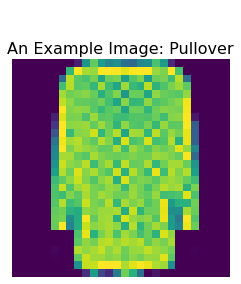

In [115]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

#####  make a request with curl and let's check the prediction

{
    "predictions": [[9.35298e-10, 1.94899985e-10, 2.85322765e-09, 7.65899622e-10, 8.67189653e-10, 3.46909e-07, 1.84958282e-09, 3.66329623e-05, 1.10681775e-08, 0.999963045]
    ]
}

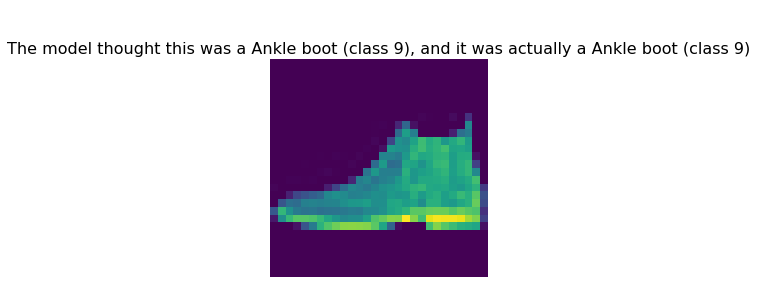

In [118]:
!curl -X POST -H 'content-type: application/json' -d "@image.json" http://localhost:8605/v1/models/mnist_model:predict
predictions = json.loads(json_response.text)['predictions']


show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

Now let's create the JSON object for a batch of  five inference requests, and see how well our model recognizes things:

In [119]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:5].tolist()})
#print(data)
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests



We'll send a predict request as a POST to our server's REST endpoint at http://localhost:8605/v1/models/mnist_model:predict, and pass it five examples.  

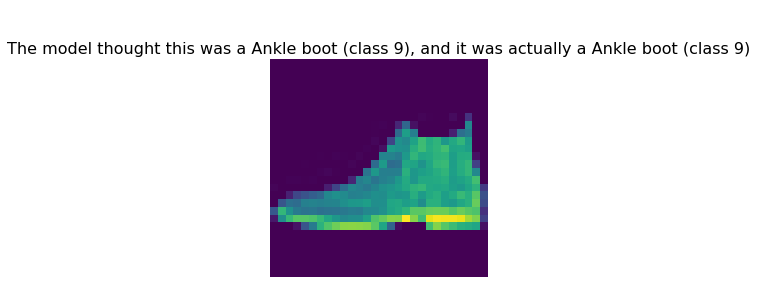

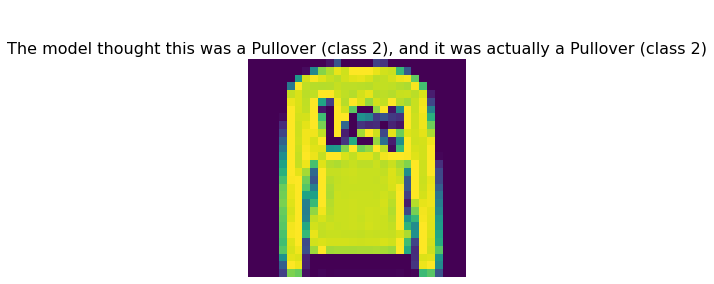

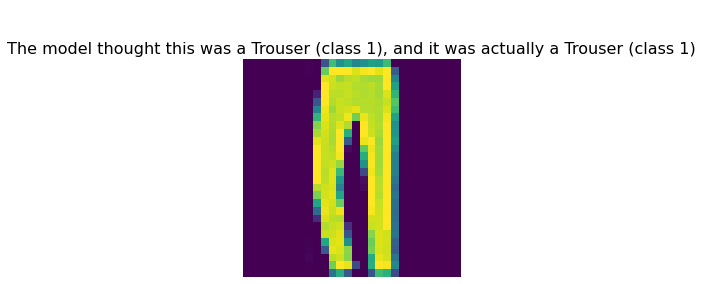

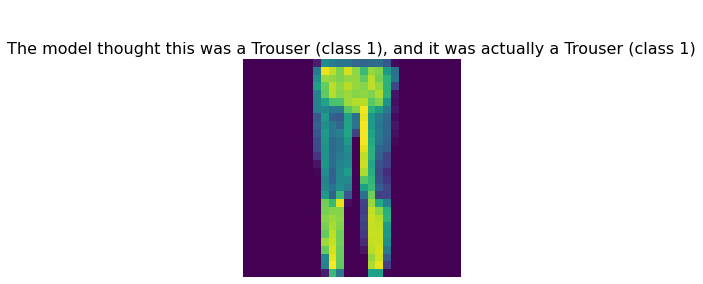

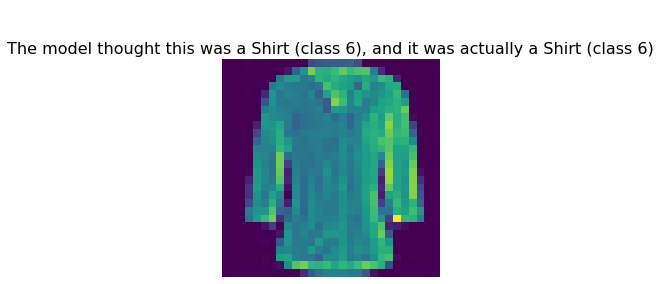

In [121]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8605/v1/models/mnist_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,5):
    show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
      class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))